In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Load the data
df = pd.read_csv('combined.csv')


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323331 entries, 0 to 323330
Columns: 101 entries, flow ID to Label
dtypes: float64(37), int64(58), object(6)
memory usage: 249.1+ MB


In [3]:
# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Columns to remove, including IP addresses and ports which might not generalize well
columns_to_drop = ["flow ID", "source IP", "destination IP", "source port", "destination port", "date"]
df = df.drop(columns=columns_to_drop)

In [4]:

# Encoding categorical variables, including the 'Label' column
label_encoders = {}
categorical_columns = ['protocol', 'firstPacketDIR', 'mostCommonREQ_FUNC_CODE', 'mostCommonRESP_FUNC_CODE', 'Label']  # Include 'Label' as categorical
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [5]:
# Store the encoded labels separately and drop from dataframe
y = df['Label']
X = df.drop('Label', axis=1)


In [6]:
from sklearn.feature_selection import mutual_info_classif

# Assuming 'X' is your feature set and 'y' is the labels
info_gain = mutual_info_classif(X, y)
feature_scores = dict(zip(X.columns, info_gain))
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Display sorted features by information gain
for feature, score in sorted_features:
    print(f"{feature}: {score}")


DLpktLenSTD: 1.3682367016059025
TRpktLenSTD: 1.3677833614228225
DLpktLenVAR: 1.3671581886463224
TRpktLenVAR: 1.3669995173941656
APPpktLenVAR: 1.3651600551775671
APPpktLenSTD: 1.3633520161806323
TRpktLenMEAN: 1.36250844707615
DLpktLenMEAN: 1.361822090833583
APPpktLenMEAN: 1.3612682936221625
APPflowBytes/sec: 1.3465902232288571
TotLenfwdTR: 1.3450019515113347
TotLenfwdAPP: 1.3434469204304553
DLflowBytes/sec: 1.3417283416635963
TRflowBytes/sec: 1.340336982061242
TotLenfwdDL: 1.3244921439935886
fwdIAT_MIN: 1.3101673293726648
DLfwdPktLenSTD: 1.3070452745668542
APPfwdPktLenSTD: 1.3070203507948204
TRfwdPktLenSTD: 1.3050945594151935
TRfwdPktLenMEAN: 1.249596978315098
DLfwdPktLenMEAN: 1.2493561808531162
APPfwdPktLenMEAN: 1.2492099300598363
FlowIAT_MEAN: 1.1288146013342388
fwdIAT_MEAN: 1.1179535594370136
FlowPkts/sec: 1.103823636065241
fwdPkts/sec: 1.081605514798175
bwdIAT_MEAN: 1.064982559344628
TotLenbwdTR: 1.0449713551541726
TotLenbwdDL: 1.0444609192655825
TotLenbwdAPP: 1.0386135336212827
bwd

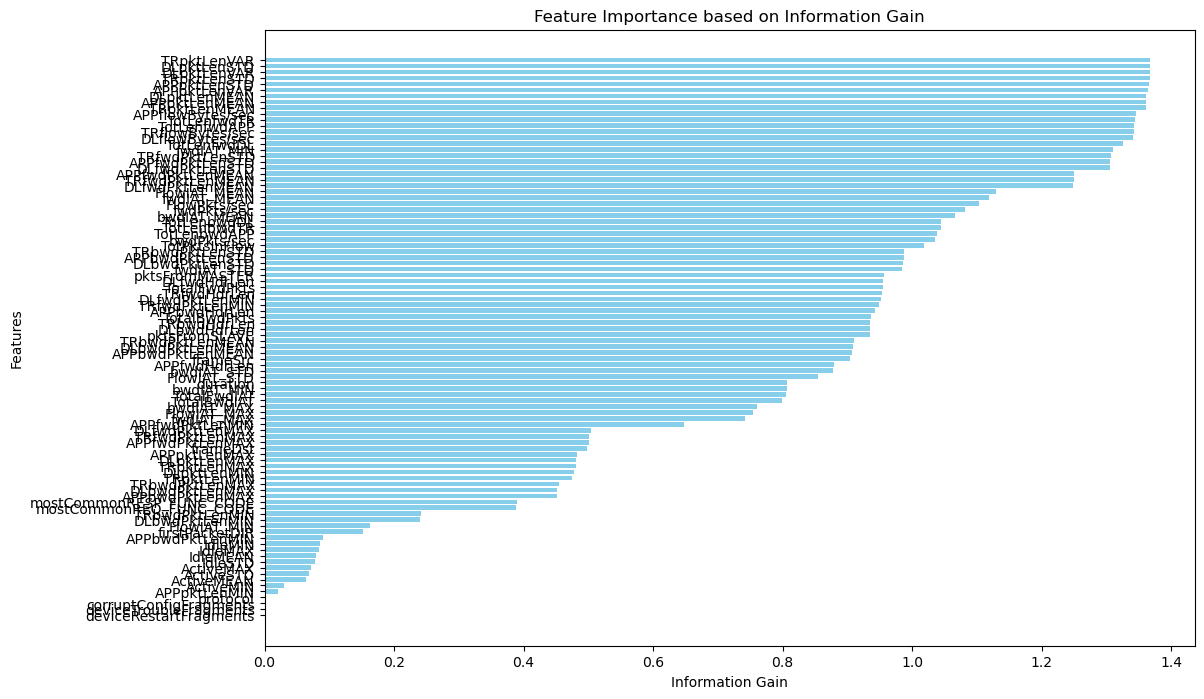

In [8]:
import matplotlib.pyplot as plt

# Assuming 'X' is your feature set and 'y' is the labels
info_gain = mutual_info_classif(X, y)
feature_scores = dict(zip(X.columns, info_gain))

# Sort features by information gain in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
features, scores = zip(*sorted_features)

# Create bar plot
plt.figure(figsize=(12, 8))
plt.barh(features, scores, color='skyblue')
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.title('Feature Importance based on Information Gain')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest values on top
plt.show()


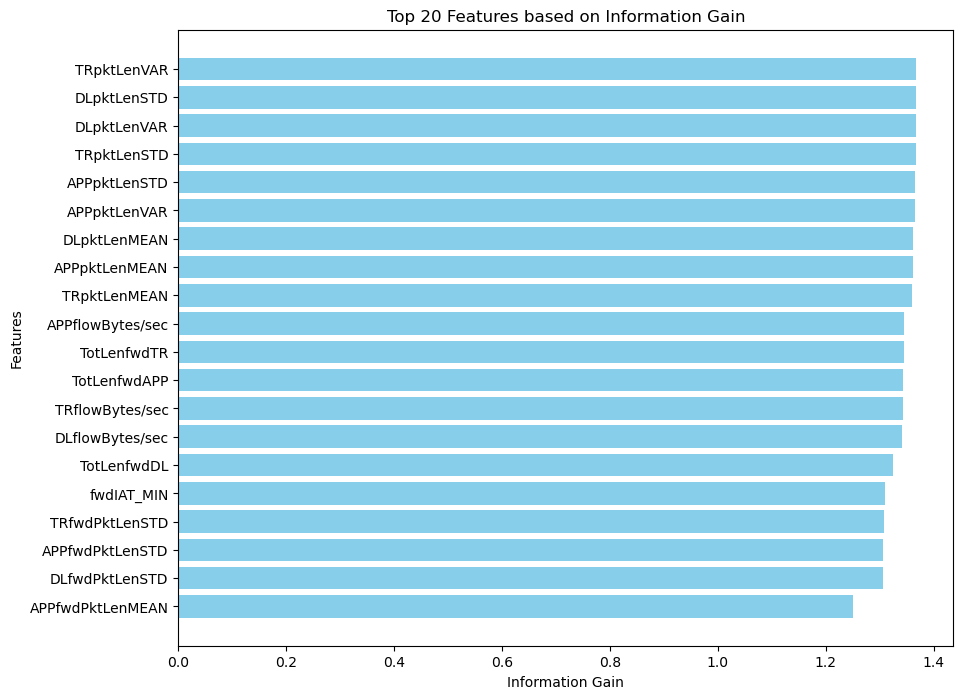

In [10]:
# Adjust N to display top N features
N = 20
top_features, top_scores = features[:N], scores[:N]

plt.figure(figsize=(10, 8))
plt.barh(top_features, top_scores, color='skyblue')
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.title('Top 20 Features based on Information Gain')
plt.gca().invert_yaxis()
plt.show()


In [13]:
import numpy as np

def entropy(y):
    """Calculate the entropy of label array y."""
    n_labels = len(y)
    if n_labels <= 1:
        return 0

    value, counts = np.unique(y, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0
    return -np.sum(probs * np.log2(probs))

# Example: Calculating entropy for the entire label set
total_entropy = entropy(y)
print("Total Entropy of Dataset:", total_entropy)

# Calculate entropy after a split (e.g., splitting by a categorical feature)
def entropy_of_split(data, split_feature):
    """Calculate the entropy of a split."""
    unique_classes = np.unique(data[split_feature])
    total_rows = len(data)
    entropy_after_split = 0

    for cls in unique_classes:
        subset = data[data[split_feature] == cls]
        subset_entropy = entropy(subset['Label'])
        entropy_after_split += (len(subset) / total_rows) * subset_entropy

    return entropy_after_split

# Example usage with a feature
feature_entropy = entropy_of_split(df, 'protocol')
print(f"Entropy after splitting on protocol: {feature_entropy}")


Total Entropy of Dataset: 2.625399397199812
Entropy after splitting on protocol: 2.625399397199812


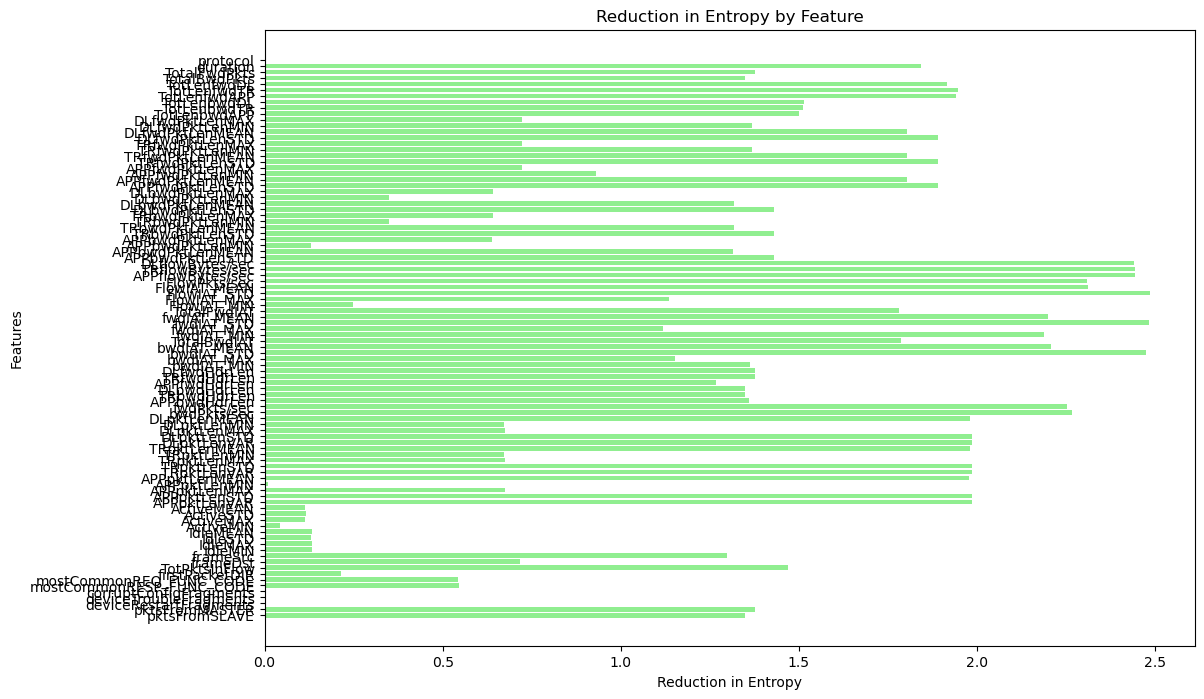

In [14]:
features = df.columns.drop('Label')  # Exclude label from features
entropy_reductions = {feat: total_entropy - entropy_of_split(df, feat) for feat in features}

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(list(entropy_reductions.keys()), list(entropy_reductions.values()), color='lightgreen')
plt.xlabel('Reduction in Entropy')
plt.ylabel('Features')
plt.title('Reduction in Entropy by Feature')
plt.gca().invert_yaxis()
plt.show()


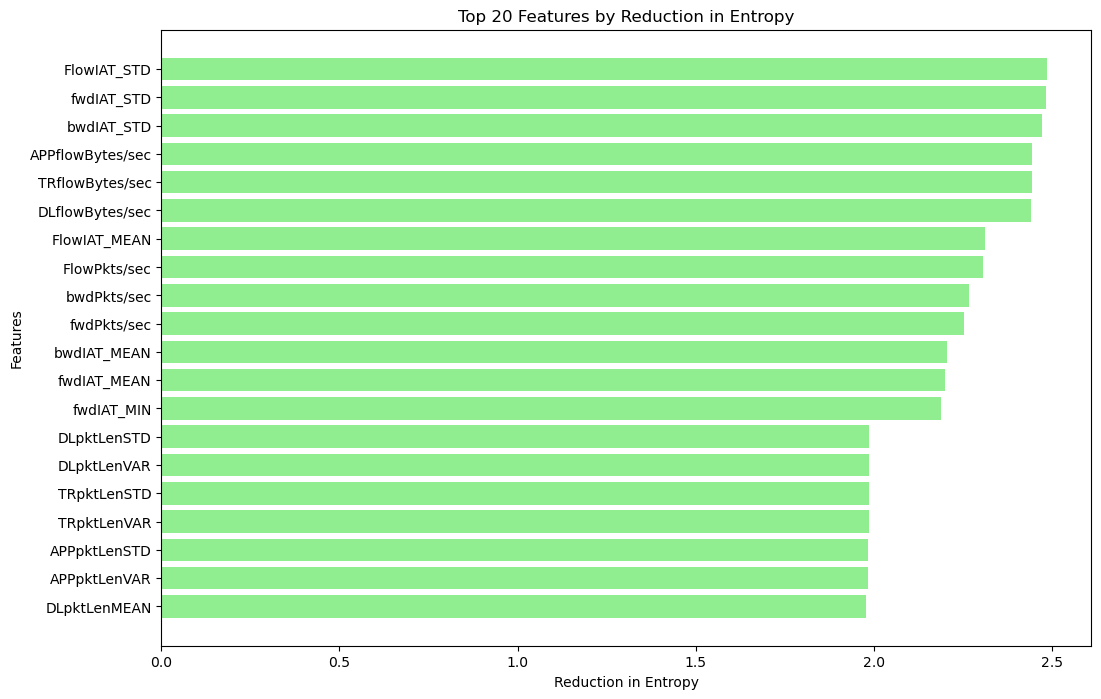

In [15]:
# Selecting top N features
top_n = 20
top_features = sorted(entropy_reductions.items(), key=lambda x: x[1], reverse=True)[:top_n]
features, reductions = zip(*top_features)

plt.figure(figsize=(12, 8))
plt.barh(features, reductions, color='lightgreen')
plt.xlabel('Reduction in Entropy')
plt.ylabel('Features')
plt.title('Top 20 Features by Reduction in Entropy')
plt.gca().invert_yaxis()
plt.show()


In [5]:
# Feature scaling
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()  # Only scale numerical columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [6]:
# Handling imbalanced dataset with SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)


In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)


In [8]:
# Model definitions with a hyperparameter grid suitable for RandomizedSearch
model_params = {
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [10, 20, 30, None],  # Possible depths of the tree
            "min_samples_leaf": [1, 2, 4],    # Minimum number of samples required at each leaf node
            "criterion": ["gini", "entropy"]  # Function to measure the quality of a split
        }
    }
}

In [9]:
# Randomized search for hyperparameter tuning
n_iter_search = 20  # Number of parameter settings that are sampled
for model_name, mp in model_params.items():
    random_search = RandomizedSearchCV(mp['model'], param_distributions=mp['params'], 
                                       n_iter=n_iter_search, cv=5, scoring='accuracy',
                                       random_state=42, return_train_score=False)
    random_search.fit(X_train, y_train)
    y_pred = random_search.predict(X_test)
    
    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")

Best parameters for Decision Tree: {'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     32590
           1       1.00      1.00      1.00     32681
           2       0.75      0.74      0.74     32310
           3       0.74      0.75      0.75     32706
           4       0.96      0.97      0.96     32617
           5       1.00      1.00      1.00     32661
           6       1.00      1.00      1.00     32516
           7       0.97      0.96      0.96     32701
           8       0.81      0.81      0.81     32514

    accuracy                           0.89    293296
   macro avg       0.89      0.89      0.89    293296
weighted avg       0.89      0.89      0.89    293296



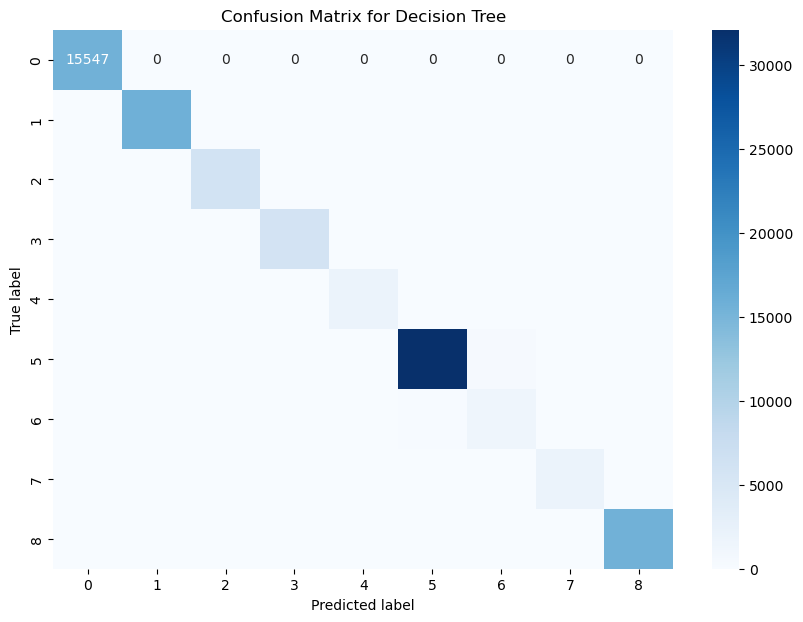

Text(0.5, 1.0, 'Receiver Operating Characteristic for Decision Tree')

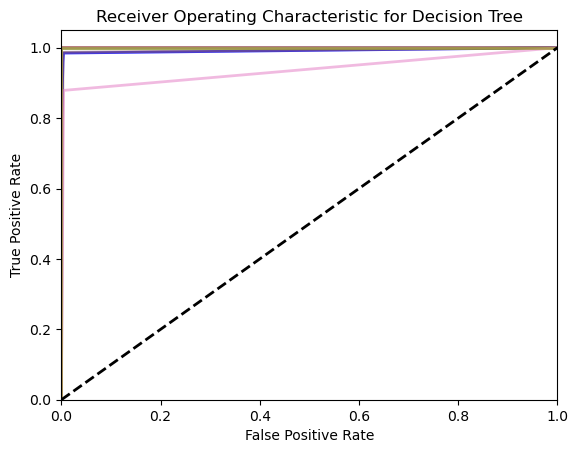

In [34]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for Decision Tree')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calculate ROC AUC for multi-class
y_test_bin = label_binarize(y_test, classes=[i for i in range(len(label_encoders['Label'].classes_))])
y_pred_bin = label_binarize(y_pred, classes=[i for i in range(len(label_encoders['Label'].classes_))])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoders['Label'].classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(label_encoders['Label'].classes_))]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(label_encoders['Label'].classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= len(label_encoders['Label'].classes_)

# Plot all ROC curves
plt.figure()
plt.plot(all_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {auc(all_fpr, mean_tpr):.2f})', lw=2, alpha=0.8)
for i in range(len(label_encoders['Label'].classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, alpha=0.5, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Decision Tree')

In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

# Load the data
df = pd.read_csv('combined.csv')

# Example preprocessing steps (adapt based on your specific dataset)
label_encoders = {}
for col in df.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Assuming 'Label' is the column to predict
y = df['Label']
X = df.drop('Label', axis=1)

# Calculate information gain for each feature
info_gain = mutual_info_classif(X, y)
feature_scores = dict(zip(X.columns, info_gain))

# Sort features by information gain and select top 20
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
top_features = sorted_features[:20]
top_feature_names = [feature[0] for feature in top_features]

# Filter the DataFrame to include only the top 20 features
X_top = X[top_feature_names]

# Optionally, save the filtered DataFrame to a new CSV
X_top.to_csv('filtered_top_20_features.csv', index=False)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load your dataset
# df = pd.read_csv('your_data.csv')  # Uncomment this line if you haven't loaded your data

# Assuming X_top is the DataFrame with the top 20 features and y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the labels on the test set
y_pred = clf.predict(X_test)


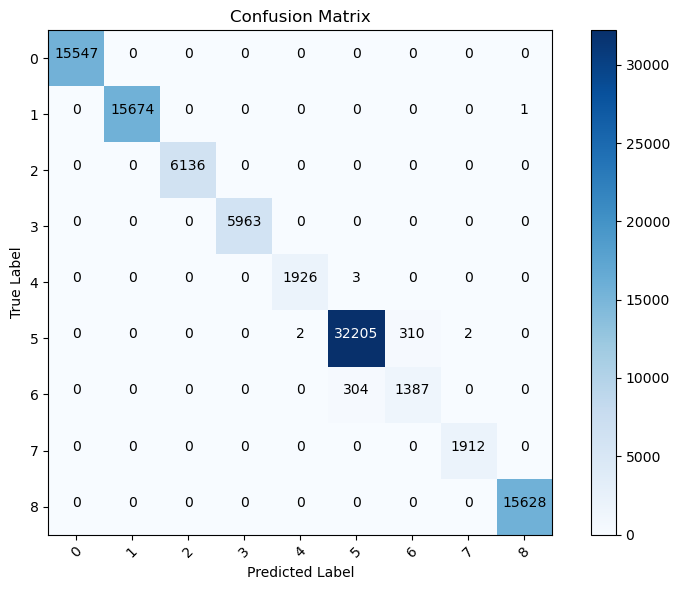

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_pred and y_test have been defined from your Decision Tree predictions
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Labeling the squares with the respective counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()



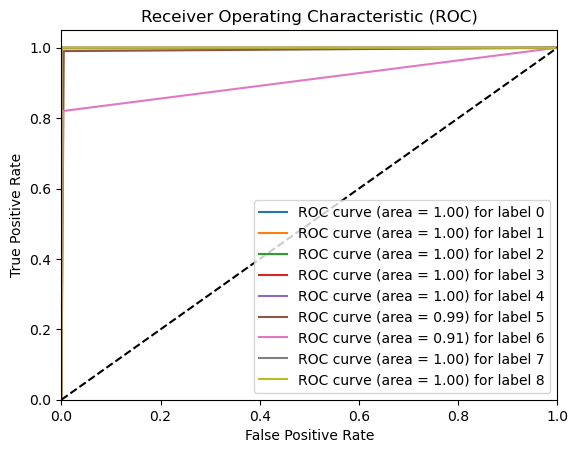

In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curve for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [23]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Assuming y_test and y_pred are defined from your model's predictions
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Add accuracy to the DataFrame
report_df.loc['accuracy'] = [accuracy, '', '', '']  # Only populate the 'precision' column with accuracy

# Print the table
print(report_df)



              precision    recall  f1-score  support
0              1.000000       1.0       1.0  15547.0
1              1.000000  0.999936  0.999968  15675.0
2              1.000000       1.0       1.0   6136.0
3              1.000000       1.0       1.0   5963.0
4              0.998963  0.998445  0.998704   1929.0
5              0.990557  0.990344  0.990451  32519.0
6              0.817325  0.820225  0.818772   1691.0
7              0.998955       1.0  0.999477   1912.0
8              0.999936       1.0  0.999968  15628.0
accuracy       0.993588                             
macro avg      0.978415  0.978772  0.978593  97000.0
weighted avg   0.993598  0.993588  0.993593  97000.0


/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_4959/251533167.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  report_df.loc['accuracy'] = [accuracy, '', '', '']  # Only populate the 'precision' column with accuracy


In [22]:
# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Optionally, add the overall accuracy as a new row
report_df.loc['accuracy'] = [accuracy, '', '', '']  # Filling other columns with empty strings


/var/folders/s0/2twvhfs95kz1b69bck8s47140000gn/T/ipykernel_4959/1207045615.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  report_df.loc['accuracy'] = [accuracy, '', '', '']  # Filling other columns with empty strings


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clf, X_top, y, cv=5)  # Using 5-fold cross-validation
print("Cross-validated accuracy scores:", scores)
print("Mean cross-validated accuracy:", scores.mean())


Cross-validated accuracy scores: [0.78435678 0.99766492 0.99342777 0.99294838 0.75266755]
Mean cross-validated accuracy: 0.9042130815056393


In [25]:
clf = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20, min_samples_leaf=10)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

In [26]:
importances = clf.feature_importances_
feature_importance = pd.DataFrame({'feature': X_top.columns, 'importance': importances})
print(feature_importance.sort_values(by='importance', ascending=False))


              feature  importance
2                date    0.583018
0             flow ID    0.294050
17        TotLenfwdDL    0.053362
15       TotLenfwdAPP    0.044608
11      APPpktLenMEAN    0.016633
18         fwdIAT_MIN    0.002454
10       TRpktLenMEAN    0.002278
12   APPflowBytes/sec    0.001425
14    TRflowBytes/sec    0.000674
19    APPfwdPktLenSTD    0.000437
16    DLflowBytes/sec    0.000418
5        APPpktLenVAR    0.000169
9        DLpktLenMEAN    0.000155
13        TotLenfwdTR    0.000123
7         TRpktLenSTD    0.000111
8        APPpktLenSTD    0.000035
6         TRpktLenVAR    0.000032
1         source port    0.000015
4         DLpktLenSTD    0.000003
3         DLpktLenVAR    0.000000


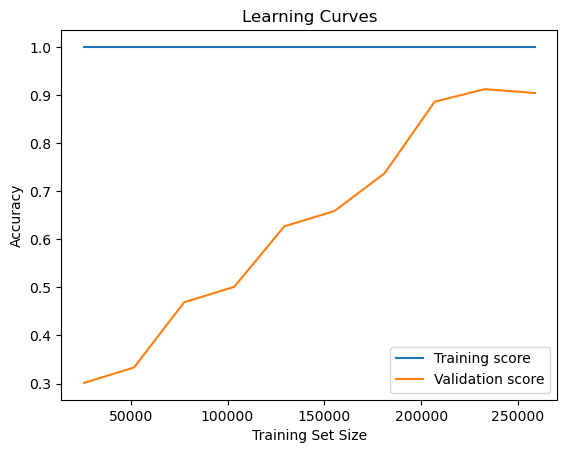

In [27]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = DecisionTreeClassifier(random_state=42),
    X = X_top,
    y = y,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 5,
    scoring = 'accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation score')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming X_top and y have been defined and are your dataset features and labels
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.3, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the balance of the target classes
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_smote))


Before SMOTE: [36437 36309 14144 14089  4535 76109  3812  4540 36356]
After SMOTE: [76109 76109 76109 76109 76109 76109 76109 76109 76109]


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train the model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.9934742268041237
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     15547
           1       1.00      1.00      1.00     15675
           2       1.00      1.00      1.00      6136
           3       1.00      1.00      1.00      5963
           4       1.00      1.00      1.00      1929
           5       0.99      0.99      0.99     32519
           6       0.78      0.88      0.83      1691
           7       1.00      1.00      1.00      1912
           8       1.00      1.00      1.00     15628

    accuracy                           0.99     97000
   macro avg       0.97      0.98      0.98     97000
weighted avg       0.99      0.99      0.99     97000

